In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2023-06-22 19:48 (eradiate v0.23.2rc2.post1.dev5+gedede817.d20230622)*

## Importing modules

In [2]:
%load_ext eradiate
import eradiate
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from eradiate.scenes.atmosphere import MolecularAtmosphere
from eradiate import unit_registry as ureg

We will perform simulations in narrow bands using Eradiate's correlated-*k* distribution mode (`ckd`). There is indeed little point performing monochromatic simulations, at least in this tutorial: running such simulations to compute the signal recorded for a given spectral band is very costly, and the CKD method brings in a significant speed-up.

In [4]:
eradiate.set_mode("ckd")

## Creating a standard molecular atmosphere

In [5]:
us_standard_atmosphere = MolecularAtmosphere.afgl_1986()

We just instantiated an molecular atmosphere object with default parameters. It notably uses the "U.S. Standard" reference atmospheric profile, default molecular density values and discretises the atmosphere vertically in 120 1 km-thick layers:

In [6]:
us_standard_atmosphere

MolecularAtmosphere(id='atmosphere', geometry=PlaneParallelGeometry(toa_altitude=120.0 km, ground_altitude=0.0 km, zgrid=ZGrid(levels=[0.0 100.0 200.0 ... 119800.0 119900.0 120000.0] m, _layers=[50.0 150.0 250.0 ... 119750.0 119850.0 119950.0] m, _layer_height=100.0 m, _total_height=120000.0 m), width=1000000.0 km), scale=None, _thermoprops=<xarray.Dataset | source='/Users/leroyv/Documents/src/rayference/rtm/eradiate/resources/data/thermoprops/afgl_1986-us_standard.nc'>, _phase=RayleighPhaseFunction(id='phase_atmosphere'), has_absorption=True, has_scattering=True, absorption_dataset=<xarray.Dataset | source='/Users/leroyv/Documents/src/rayference/rtm/eradiate/resources/downloads/unstable/ckd/absorption/10nm/afgl_1986-us_standard-10nm-v3.nc'>)

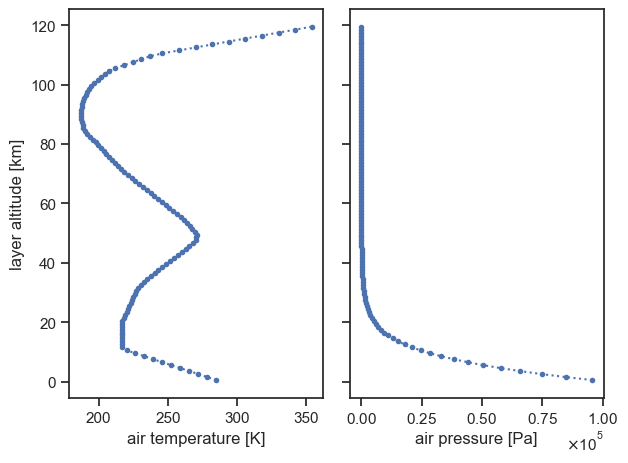

In [7]:
def show_profile(*atmospheres, labels=None):
    from matplotlib.ticker import ScalarFormatter
    
    if labels is None:
        label_iter = iter([None for _ in atmospheres])
    else:
        label_iter = iter(labels)

    fig, axs = plt.subplots(1, 2, sharey=True)
    
    for atmosphere in atmospheres:
        temperature = atmosphere.radprops_profile.thermoprops.t
        pressure = atmosphere.radprops_profile.thermoprops.p

        with plt.rc_context({"lines.linestyle": ":", "lines.marker": "."}):
            temperature.plot(y="z_layer", ax=axs[0])
            pressure.plot(y="z_layer", ax=axs[1], label=next(label_iter))

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3,2))
    axs[1].xaxis.set_major_formatter(formatter)
    axs[1].set_ylabel("")
    
    if labels is not None:
        fig.legend(
        bbox_to_anchor=(1.0, 0.5), 
        loc="center left", 
        borderaxespad=0.0,
    )

    plt.tight_layout()
    plt.show()
    plt.close()

show_profile(us_standard_atmosphere)

The reference atmosphere is controlled by the `model` parameter. For instance, the *Midlatitude Summer* reference atmosphere can be obtained with the `midlatitude_summer` value. Let's add it to our plot:

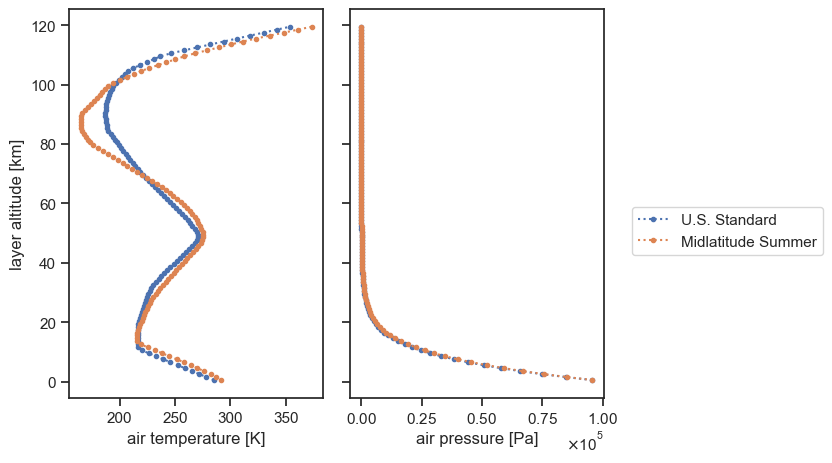

In [8]:
midlatitude_summer_atmosphere = MolecularAtmosphere.afgl_1986(
    model="midlatitude_summer"
)
show_profile(
    us_standard_atmosphere,
    midlatitude_summer_atmosphere,
    labels=["U.S. Standard", "Midlatitude Summer"],
)

## Changing the altitude grid

The altitude grid can be specified manually using the `levels` parameter. To change the number of levels to 26 (25 layers) and have the profile extend between 0 and 100 km, we simply have to write:

In [9]:
us_standard_atmosphere_custom = MolecularAtmosphere.afgl_1986(
    model="us_standard",
    levels=np.linspace(0, 100, 26) * ureg.km,
)

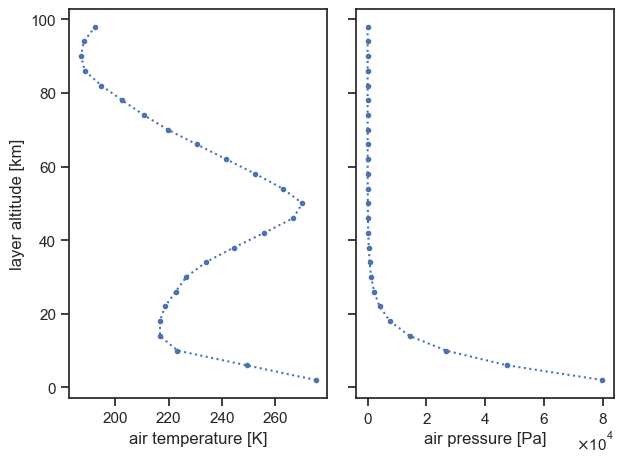

In [10]:
show_profile(us_standard_atmosphere_custom)

tutorials/getting_started/molecular_atmosphere.ipynb## Rescaling species concentration values

Arguably, reference atmospheric profiles are not always appropriate. In particular, the chemical composition of the atmosphere significantly varies as a function of time and location. Eradiate can vary reference profiles by *rescaling* species concentrations to account for the effects of a changing atmospheric composition. This is done using the `concentrations` parameter. The following example varies the U.S. Standard atmosphere by setting:

* the column mass density of water vapour to 15 kg / m²,
* the volume mixing ratio of CO₂ at sea level to 400 ppm,
* the column number density of O₃ to 350 Dobson units.

In [11]:
us_standard_atmosphere_custom = MolecularAtmosphere.afgl_1986(
    model="us_standard",
    concentrations={
        "H2O": 15.0 * ureg.kg / ureg.m ** 2,  # column mass density
        "CO2": 400e-6 * ureg.dimensionless,  # volume mixing fraction at sea level
        "O3": 350.0 * ureg.dobson_units,  # column number density
    },
)

## Disabling absorption or scattering

The absorption or scattering coefficient can be forced to 0 using the `has_absorption` and `has_scattering` switches. The following atmosphere definition has no absorption, only Rayleigh scattering:

In [12]:
rayleigh_atmosphere = MolecularAtmosphere.afgl_1986(
    has_absorption=False, has_scattering=True
)

In [13]:
us76_atmosphere = MolecularAtmosphere.ussa_1976()

Profile customisation options are similar to those of the AFGL 1986 profiles.